# CTPN

In [24]:
from __future__ import print_function

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from lib.fast_rcnn.config import cfg, cfg_from_file
from lib.fast_rcnn.test import _get_blobs
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg
from lib.rpn_msr.proposal_layer_tf import proposal_layer

In [25]:
cfg_from_file('ctpn/text.yml')

# init session
config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=config)
with gfile.FastGFile('data/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
sess.run(tf.global_variables_initializer())

input_img = sess.graph.get_tensor_by_name('Placeholder:0')
output_cls_prob = sess.graph.get_tensor_by_name('Reshape_2:0')
output_box_pred = sess.graph.get_tensor_by_name('rpn_bbox_pred/Reshape_1:0')

In [26]:
def resize_im(im, scale, max_scale=None):
    f = float(scale) / min(im.shape[0], im.shape[1])
    if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
        f = float(max_scale) / max(im.shape[0], im.shape[1])
    return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f


def draw_boxes(img, image_name, boxes, scale, bbox):
    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue
        if box[8] >= 0.9:
            color = (0, 255, 0)
        elif box[8] >= 0.8:
            color = (255, 0, 0)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[4]), int(box[5])), color, 2)
        cv2.line(img, (int(box[6]), int(box[7])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[4]), int(box[5])), (int(box[6]), int(box[7])), color, 2)

        min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        
        bbox.append([min_x, min_y, max_x, max_y])

    img = cv2.resize(img, None, None, fx=1.0 / scale, fy=1.0 / scale, interpolation=cv2.INTER_LINEAR)


im_name = "data/demo/jaket3.jpg"
img = cv2.imread(im_name)
img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
blobs, im_scales = _get_blobs(img, None)
if cfg.TEST.HAS_RPN:
    im_blob = blobs['data']
    blobs['im_info'] = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
        dtype=np.float32)
cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

scores = rois[:, 0]
boxes = rois[:, 1:5] / im_scales[0]
textdetector = TextDetector()
boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
bbox = []
draw_boxes(img, im_name, boxes, scale, bbox)

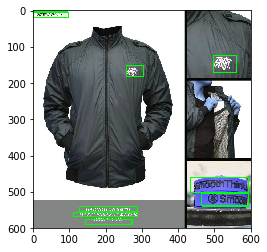

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline  

# draw image
plt.figure()
plt.imshow(img)

In [28]:
imgs = []
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
    crop_img = cv2.resize(crop_img, None, fx = 2, fy = 2.4, interpolation = cv2.INTER_CUBIC)
    # gaussian_3 = cv2.GaussianBlur(crop_img, (9,9), 10.0)
    # unsharp_image = cv2.addWeighted(crop_img, 1.5, gaussian_3, -0.5, 0, crop_img)

    # blurred_f = ndimage.gaussian_filter(crop_img, 3)
    # filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    # alpha = 5
    # sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

    imgs.append(crop_img)

In [30]:
# ga tahu kenapa di notebook ada beberapa warna yang berubah

# for i in imgs :
#     plt.figure()
#     plt.imshow(i)